In [10]:
import pandas as pd
import torch
import torch.cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from vocabulary import Vocabulary
from torch.optim import Adam
import os
import numpy as np
# import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
# import input_model
from statistics import mean
from sklearn import metrics
from sklearn.model_selection import train_test_split



## build regression model

### 1. VRC01 transformer

In [2]:
data = pd.read_csv('./data/processed_data2/VRC01.csv')
data = data[data["IC50"] != 100]

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [3]:
torch.cuda.is_available()

True

In [4]:
vocabulary.vocabulary

{'M': 11,
 'R': 15,
 'V': 18,
 'K': 9,
 'G': 6,
 'I': 8,
 'L': 10,
 'N': 12,
 'Y': 20,
 'Q': 14,
 'W': 19,
 'S': 16,
 'F': 5,
 'C': 2,
 'T': 17,
 'P': 13,
 'E': 4,
 'A': 1,
 'D': 3,
 'H': 7,
 '<pad>': 0,
 '<start>': 21,
 '<end>': 22}

In [5]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [6]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.v2_clear.values
        eval_data = df_eval.v2_clear.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 50)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [7]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [8]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [9]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input.shape)
    print(input)
    print(target)
    break

AttributeError: 'DataFrame' object has no attribute 'v2_clear'

In [41]:
# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        # Embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Transformer编码器
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # Transformer编码器
        x = self.encoder(x)
        
        # 平均池化
        # x = torch.mean(x, dim=1)
        
        # 输出层
        x = self.output_layer(x)
        # x = self.activation(x)
        return x



In [38]:
# 设置超参数
input_size = len(vocabulary.vocabulary)  # 输入序列的词汇大小
output_size = 1  # 输出的数值大小
hidden_size = 64  # 隐藏层大小
num_layers = 4  # Transformer编码器的层数
num_heads = 4  # 注意力头的数量
dropout = 0.1  # Dropout率
batch_size = 32  # 批处理大小
num_epochs = 300  # 训练轮数
learning_rate = 0.001  # 学习率


In [42]:
# 创建模型和优化器
model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# if os.path.exists("./model/pickles/model_VCR01.pkl"):
#     model.load_state_dict(torch.load("./model/pickles/model_VCR01.pkl"))
#     optimizer.load_state_dict(torch.load("./model/pickles/optimizer_VCR01.pkl"))



In [43]:
# 训练模型
loss_item = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # if index%100 == 0:
        #     torch.save(model.state_dict(), "./model/pickles/model_VRC01_v_loop.pkl")
        #     torch.save(optimizer.state_dict(), "./model/pickles/optimizer_VRC01_v_loop.pkl")
    # print(len(loss_list))
    
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

第1个epoch, mean_loss:15.11
第2个epoch, mean_loss:14.93
第3个epoch, mean_loss:14.85
第4个epoch, mean_loss:14.87
第5个epoch, mean_loss:15.29
第6个epoch, mean_loss:14.85
第7个epoch, mean_loss:14.9
第8个epoch, mean_loss:14.86
第9个epoch, mean_loss:14.88
第10个epoch, mean_loss:21.13
第11个epoch, mean_loss:15.31
第12个epoch, mean_loss:15.12
第13个epoch, mean_loss:15.33
第14个epoch, mean_loss:14.88
第15个epoch, mean_loss:14.87
第16个epoch, mean_loss:14.9
第17个epoch, mean_loss:15.25
第18个epoch, mean_loss:14.84
第19个epoch, mean_loss:14.88
第20个epoch, mean_loss:14.86
第21个epoch, mean_loss:14.92
第22个epoch, mean_loss:15.49
第23个epoch, mean_loss:14.85
第24个epoch, mean_loss:14.86
第25个epoch, mean_loss:14.88
第26个epoch, mean_loss:14.86
第27个epoch, mean_loss:14.85
第28个epoch, mean_loss:15.08
第29个epoch, mean_loss:14.86
第30个epoch, mean_loss:16.31
第31个epoch, mean_loss:15.08
第32个epoch, mean_loss:14.85
第33个epoch, mean_loss:14.88
第34个epoch, mean_loss:14.87
第35个epoch, mean_loss:14.99
第36个epoch, mean_loss:14.89
第37个epoch, mean_loss:14.97
第38个epoch, m

KeyboardInterrupt: 

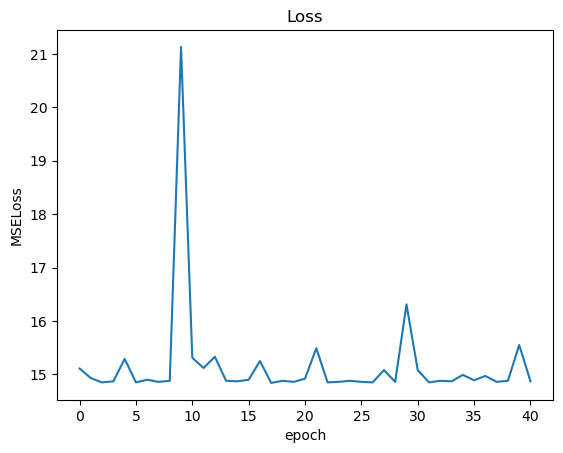

In [44]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()

In [15]:
#  模型评估 RMSE和R2
RMSE = []
R2 = []

if os.path.exists("./model/pickles/model_VCR01.pkl"):
    model.load_state_dict(torch.load("./model/pickles/model_VCR01.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_VCR01.pkl"))
else:
    print("Can not find this model!!!!")



### VRC01 线性回归模型

In [45]:
data = pd.read_csv('./data/processed_data2/VRC01.csv')
data = data[data["IC50"] != 100]

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [47]:
vocabulary.vocabulary

{'M': 11,
 'R': 15,
 'V': 18,
 'K': 9,
 'G': 6,
 'I': 8,
 'L': 10,
 'N': 12,
 'Y': 20,
 'Q': 14,
 'W': 19,
 'S': 16,
 'F': 5,
 'C': 2,
 'T': 17,
 'P': 13,
 'E': 4,
 'A': 1,
 'D': 3,
 'H': 7,
 '<pad>': 0,
 '<start>': 21,
 '<end>': 22}

In [48]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [49]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.v_loop_clear.values
        eval_data = df_eval.v_loop_clear.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 140)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [50]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.FloatTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [51]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [52]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input.shape)
    print(input)
    print(target)
    break

0
torch.Size([128, 140])
tensor([[21., 16.,  4.,  ...,  0.,  0.,  0.],
        [21.,  6., 12.,  ...,  0.,  0.,  0.],
        [21., 16.,  4.,  ...,  0.,  0.,  0.],
        ...,
        [21., 17.,  3.,  ...,  0.,  0.,  0.],
        [21., 12.,  1.,  ...,  0.,  0.,  0.],
        [21., 17., 12.,  ...,  0.,  0.,  0.]])
tensor([4.4000e-01, 1.3070e+01, 7.6000e-02, 3.4000e-01, 2.6000e-01, 9.8000e-02,
        7.2000e-01, 5.8800e-01, 2.9000e-01, 1.5000e-01, 5.0000e-02, 1.4000e-01,
        1.6060e-01, 1.0000e-02, 1.5410e-01, 1.7900e+00, 5.0500e-01, 5.4560e+00,
        3.3405e+00, 2.7540e-01, 1.9530e-01, 8.0000e-02, 2.0446e+01, 6.9800e+00,
        4.9720e-01, 6.5800e-02, 1.8870e+00, 1.8900e-02, 1.6200e+01, 8.5000e-01,
        3.0000e-01, 1.5600e-01, 9.2626e+00, 1.0510e-01, 1.7120e+00, 8.8300e-02,
        7.7000e-01, 1.6600e-01, 2.9000e-02, 9.5000e-02, 7.7300e-02, 1.5098e+00,
        1.1600e+00, 3.9000e-02, 6.0000e-02, 2.3090e-01, 3.5600e-02, 9.2000e-02,
        2.0000e-02, 2.5000e-01, 2.1800e+00, 1

In [53]:
# Define the regression model
class ProteinRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ProteinRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = 140  # Example input size (length of encoded protein sequence)
hidden_size = 64  # Number of hidden units
num_epochs = 300

In [54]:
# Create the model
model = ProteinRegressionModel(input_size, hidden_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# if os.path.exists("./model/pickles/model_VCR01.pkl"):
#     model.load_state_dict(torch.load("./model/pickles/model_VCR01.pkl"))
#     optimizer.load_state_dict(torch.load("./model/pickles/optimizer_VCR01.pkl"))



In [55]:
# 训练模型
loss_item = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # if index%100 == 0:
        #     torch.save(model.state_dict(), "./model/pickles/model_VRC01_v_loop.pkl")
        #     torch.save(optimizer.state_dict(), "./model/pickles/optimizer_VRC01_v_loop.pkl")
    # print(len(loss_list))
    
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([45])) that is different to the input size (torch.Size([45, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第1个epoch, mean_loss:16.31
第2个epoch, mean_loss:15.61
第3个epoch, mean_loss:14.84
第4个epoch, mean_loss:14.33
第5个epoch, mean_loss:14.64
第6个epoch, mean_loss:15.03
第7个epoch, mean_loss:14.5
第8个epoch, mean_loss:14.76
第9个epoch, mean_loss:15.2
第10个epoch, mean_loss:14.89
第11个epoch, mean_loss:14.12
第12个epoch, mean_loss:14.62
第13个epoch, mean_loss:15.09
第14个epoch, mean_loss:14.1
第15个epoch, mean_loss:14.56
第16个epoch, mean_loss:14.67
第17个epoch, mean_loss:14.39
第18个epoch, mean_loss:14.53
第19个epoch, mean_loss:14.66
第20个epoch, mean_loss:14.32
第21个epoch, mean_loss:14.45
第22个epoch, mean_loss:15.8
第23个epoch, mean_loss:14.5
第24个epoch, mean_loss:15.76
第25个epoch, mean_loss:16.04
第26个epoch, mean_loss:14.39
第27个epoch, mean_loss:14.19
第28个epoch, mean_loss:14.12
第29个epoch, mean_loss:15.43
第30个epoch, mean_loss:14.45
第31个epoch, mean_loss:14.97
第32个epoch, mean_loss:14.08
第33个epoch, mean_loss:14.24
第34个epoch, mean_loss:14.33
第35个epoch, mean_loss:14.1
第36个epoch, mean_loss:15.17
第37个epoch, mean_loss:14.2
第38个epoch, mean_l

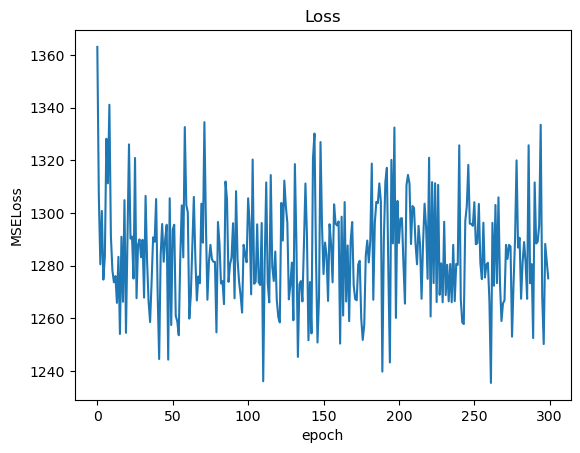

In [20]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()

### VRC01 RNN_regression

In [2]:
data = pd.read_csv('./data/processed_data2/VRC01.csv')
data = data[data["IC50"] != 100]
vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [3]:
vocabulary.vocabulary

{'M': 11,
 'R': 15,
 'V': 18,
 'K': 9,
 'G': 6,
 'I': 8,
 'L': 10,
 'N': 12,
 'Y': 20,
 'Q': 14,
 'W': 19,
 'S': 16,
 'F': 5,
 'C': 2,
 'T': 17,
 'P': 13,
 'E': 4,
 'A': 1,
 'D': 3,
 'H': 7,
 '<pad>': 0,
 '<start>': 21,
 '<end>': 22}

In [4]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [5]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.sequence.values
        eval_data = df_eval.sequence.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 870)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [6]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [7]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [8]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input.shape)
    print(input)
    print(target)
    break

0
torch.Size([32, 870])
tensor([[21, 11, 15,  ...,  0,  0,  0],
        [21, 11, 15,  ...,  0,  0,  0],
        [21, 11, 15,  ..., 10, 22,  0],
        ...,
        [21, 11, 15,  ...,  0,  0,  0],
        [21, 11, 15,  ...,  0,  0,  0],
        [21, 11,  9,  ...,  0,  0,  0]])
tensor([1.4400e+00, 7.0000e-02, 5.8130e-01, 1.1220e-01, 1.2900e+00, 1.0000e-01,
        1.4000e-01, 2.2100e+00, 1.2900e+00, 6.0000e-01, 6.2720e-01, 1.6600e-01,
        3.6800e+00, 1.3660e-01, 6.0000e-02, 1.3070e+01, 6.9000e-01, 6.0000e-02,
        4.6270e-01, 1.6000e-02, 2.0560e-01, 3.0600e-02, 4.5540e-01, 6.6400e+00,
        3.9000e-01, 3.7700e+00, 5.1200e-01, 1.0000e-02, 1.5000e-01, 1.2000e-01,
        1.9530e-01, 5.9000e-01])


In [9]:
# Define the RNN regression model
class RNNRegression(nn.Module):
    def __init__(self):
        super(RNNRegression, self).__init__()
        self.embedding = nn.Embedding(len(vocabulary.vocabulary), 24)    #每个残基用长度100的向量表示，这里没有用one-hot编码
        #加入LSTM
        self.lstm = nn.LSTM(input_size=24, hidden_size=300, num_layers=1, batch_first=True, bidirectional=False,dropout=0.1)
        self.fc = nn.Linear(300, 1)
    def forward(self, input):
        x = self.embedding(input)   #进行embedding操作,形状[batch_size, max_len,100]
        x, (h_n, c_n) = self.lstm(x)
        #x:[batch_size,max_len,hidden_size]  h_n:[2,batch_size,hiddem_size]
       
        output = h_n[-1,:,:] #正向最后一次的输出
        out = self.fc(output)
        return out

In [10]:
# Hyperparameters
input_size = len(vocabulary.vocabulary)  # Number of features
hidden_size = 64  # Number of hidden units in RNN
num_layers = 2  # Number of RNN layers
output_size = 1  # Number of output units
learning_rate = 0.001
num_epochs = 100

In [11]:
# 创建模型和优化器
model = RNNRegression().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# if os.path.exists("./model/pickles/model_VCR01.pkl"):
#     model.load_state_dict(torch.load("./model/pickles/model_VCR01.pkl"))
#     optimizer.load_state_dict(torch.load("./model/pickles/optimizer_VCR01.pkl"))



/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [22]:
model

RNNRegression(
  (embedding): Embedding(23, 24)
  (lstm): LSTM(24, 300, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [12]:
# 训练模型
loss_item = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # if index%100 == 0:
        #     torch.save(model.state_dict(), "./model/pickles/model_VRC01_v_loop.pkl")
        #     torch.save(optimizer.state_dict(), "./model/pickles/optimizer_VRC01_v_loop.pkl")
    # print(len(loss_list))
    
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第1个epoch, mean_loss:17.11
第2个epoch, mean_loss:15.33
第3个epoch, mean_loss:14.92
第4个epoch, mean_loss:15.06
第5个epoch, mean_loss:14.91
第6个epoch, mean_loss:14.87
第7个epoch, mean_loss:14.97
第8个epoch, mean_loss:15.24
第9个epoch, mean_loss:15.34
第10个epoch, mean_loss:16.06
第11个epoch, mean_loss:14.9
第12个epoch, mean_loss:14.92
第13个epoch, mean_loss:14.88
第14个epoch, mean_loss:14.89
第15个epoch, mean_loss:15.46
第16个epoch, mean_loss:15.07
第17个epoch, mean_loss:14.92
第18个epoch, mean_loss:14.85
第19个epoch, mean_loss:15.1
第20个epoch, mean_loss:14.87
第21个epoch, mean_loss:14.86
第22个epoch, mean_loss:21.08
第23个epoch, mean_loss:14.87
第24个epoch, mean_loss:15.58
第25个epoch, mean_loss:19.07
第26个epoch, mean_loss:15.54
第27个epoch, mean_loss:15.09
第28个epoch, mean_loss:14.83
第29个epoch, mean_loss:15.04
第30个epoch, mean_loss:14.88
第31个epoch, mean_loss:15.63
第32个epoch, mean_loss:14.91
第33个epoch, mean_loss:14.85
第34个epoch, mean_loss:14.96
第35个epoch, mean_loss:14.93
第36个epoch, mean_loss:14.84
第37个epoch, mean_loss:14.83
第38个epoch, m

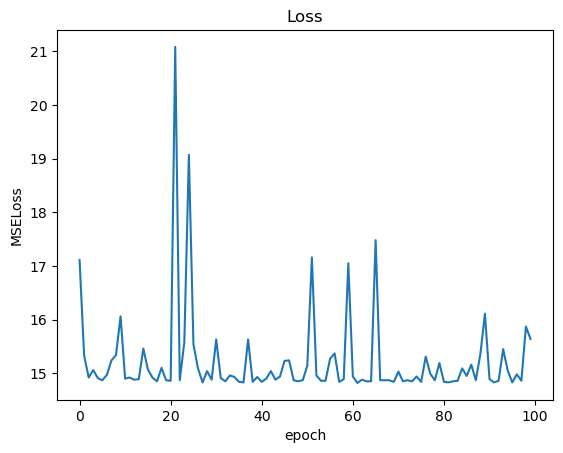

In [13]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()

In [ ]:
#  模型评估 RMSE和R2
RMSE = []
R2 = []

if os.path.exists("./model/pickles/model_VCR01.pkl"):
    model.load_state_dict(torch.load("./model/pickles/model_VCR01.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_VCR01.pkl"))
else:
    print("Can not find this model!!!!")



### 2F5

In [3]:
name = "2F5"
data = pd.read_csv('./data/processed_data/{}.csv'.format(name))

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [4]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [5]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.sequence.values
        eval_data = df_eval.sequence.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 1041)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [6]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [7]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [8]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input.shape)
    print(target)
    break

0
torch.Size([32, 1041])
tensor([ 11.2000,  20.0000,   2.1800,   1.2810,   0.4600,  50.0000, 100.0000,
          1.3200, 100.0000, 100.0000,   0.5930, 100.0000, 100.0000,   6.9910,
        100.0000, 100.0000,   4.7300, 100.0000,   0.1420,   3.9000, 100.0000,
         50.0000,   0.4680,   3.9500,   1.3390,  50.0000,   0.9600,   5.4600,
          0.6000, 100.0000,   0.2100, 100.0000])


In [9]:
# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        # Embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Transformer编码器
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # Transformer编码器
        x = self.encoder(x)
        
        # 平均池化
        x = torch.mean(x, dim=1)
        
        # 输出层
        x = self.output_layer(x)
        return x



In [10]:
# 设置超参数
input_size = len(vocabulary.vocabulary)  # 输入序列的词汇大小
output_size = 1  # 输出的数值大小
hidden_size = 256  # 隐藏层大小
num_layers = 4  # Transformer编码器的层数
num_heads = 8  # 注意力头的数量
dropout = 0.1  # Dropout率
batch_size = 32  # 批处理大小
num_epochs = 300  # 训练轮数
learning_rate = 0.01  # 学习率


In [22]:
# 创建模型和优化器
model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
if os.path.exists("./model/pickles/model_{}.pkl".format(name)):
    model.load_state_dict(torch.load("./model/pickles/model_{}.pkl".format(name)))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_{}.pkl".format(name)))



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [14]:
# 训练模型
loss_item = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        if index%100 == 0:
            torch.save(model.state_dict(), "./model/pickles/model_{}.pkl".format(name))
            torch.save(optimizer.state_dict(), "./model/pickles/optimizer_{}.pkl".format(name))
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第1个epoch, mean_loss:2300.42
第2个epoch, mean_loss:1877.81
第3个epoch, mean_loss:1883.76
第4个epoch, mean_loss:1860.41
第5个epoch, mean_loss:1863.05
第6个epoch, mean_loss:1852.95
第7个epoch, mean_loss:1867.0
第8个epoch, mean_loss:1862.74
第9个epoch, mean_loss:1860.97
第10个epoch, mean_loss:1852.17
第11个epoch, mean_loss:1866.92
第12个epoch, mean_loss:1856.63
第13个epoch, mean_loss:1853.04
第14个epoch, mean_loss:1861.59
第15个epoch, mean_loss:1864.83
第16个epoch, mean_loss:1857.57
第17个epoch, mean_loss:1854.56
第18个epoch, mean_loss:1871.73
第19个epoch, mean_loss:1880.6
第20个epoch, mean_loss:1863.15
第21个epoch, mean_loss:1853.6
第22个epoch, mean_loss:1859.71
第23个epoch, mean_loss:1863.48
第24个epoch, mean_loss:1865.02
第25个epoch, mean_loss:1858.58
第26个epoch, mean_loss:1864.39
第27个epoch, mean_loss:1876.28
第28个epoch, mean_loss:1853.14
第29个epoch, mean_loss:1854.22
第30个epoch, mean_loss:1861.94
第31个epoch, mean_loss:1867.32
第32个epoch, mean_loss:1857.47
第33个epoch, mean_loss:1869.75
第34个epoch, mean_loss:1857.5
第35个epoch, mean_loss:1861.7

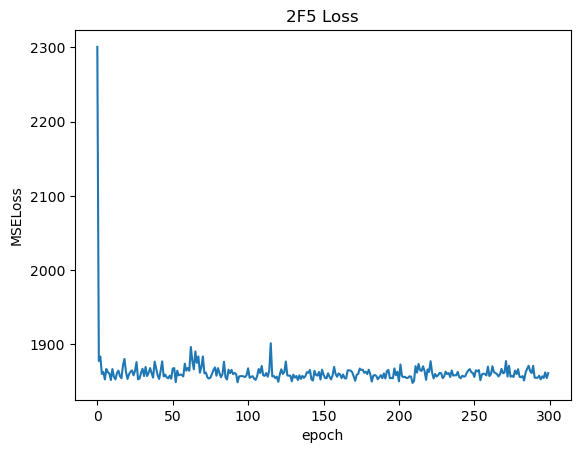

In [15]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("{} Loss".format(name))
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()

In [16]:
#  模型评估 RMSE和R2
RMSE = []
R2 = []

if os.path.exists("./model/pickles/model_{}.pkl".format(name)):
    model.load_state_dict(torch.load("./model/pickles/model_{}.pkl".format(name)))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_{}.pkl".format(name)))
else:
    print("Can not find this model!!!!")



### 2G12

In [17]:
name = "2G12"
data = pd.read_csv('./data/antibody/processed_data/{}.csv'.format(name))

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [18]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [19]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.sequence.values
        eval_data = df_eval.sequence.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 1041)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [20]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [21]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [22]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input.shape)
    print(target)
    break

0
torch.Size([32, 1041])
tensor([100.0000, 100.0000,  20.0000, 100.0000,   0.1110,  50.0000, 100.0000,
        100.0000,   2.1000, 100.0000, 100.0000,  50.0000, 100.0000, 100.0000,
        100.0000, 100.0000,   2.9000, 100.0000, 100.0000, 100.0000,   4.6230,
         50.0000,  50.0000, 100.0000, 100.0000,   0.5000,   0.1540, 100.0000,
        100.0000,  50.0000, 100.0000,  50.0000])


In [23]:
# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        # Embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Transformer编码器
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # Transformer编码器
        x = self.encoder(x)
        
        # 平均池化
        x = torch.mean(x, dim=1)
        
        # 输出层
        x = self.output_layer(x)
        return x



In [24]:
# 设置超参数
input_size = len(vocabulary.vocabulary)  # 输入序列的词汇大小
output_size = 1  # 输出的数值大小
hidden_size = 256  # 隐藏层大小
num_layers = 4  # Transformer编码器的层数
num_heads = 8  # 注意力头的数量
dropout = 0.1  # Dropout率
batch_size = 32  # 批处理大小
num_epochs = 300  # 训练轮数
learning_rate = 0.01  # 学习率


In [25]:
# 创建模型和优化器
model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
if os.path.exists("./model/pickles/model_{}.pkl".format(name)):
    model.load_state_dict(torch.load("./model/pickles/model_{}.pkl".format(name)))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_{}.pkl".format(name)))



In [26]:
# 训练模型
loss_item = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        if index%100 == 0:
            torch.save(model.state_dict(), "./model/pickles/model_{}.pkl".format(name))
            torch.save(optimizer.state_dict(), "./model/pickles/optimizer_{}.pkl".format(name))
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第1个epoch, mean_loss:2769.74
第2个epoch, mean_loss:1630.16
第3个epoch, mean_loss:1606.36
第4个epoch, mean_loss:1592.99
第5个epoch, mean_loss:1606.82
第6个epoch, mean_loss:1613.02
第7个epoch, mean_loss:1570.87
第8个epoch, mean_loss:1639.48
第9个epoch, mean_loss:1609.49
第10个epoch, mean_loss:1603.05
第11个epoch, mean_loss:1568.29
第12个epoch, mean_loss:1616.22
第13个epoch, mean_loss:1587.97
第14个epoch, mean_loss:1592.46
第15个epoch, mean_loss:1598.05
第16个epoch, mean_loss:1633.53
第17个epoch, mean_loss:1618.1
第18个epoch, mean_loss:1612.43
第19个epoch, mean_loss:1583.15
第20个epoch, mean_loss:1634.73
第21个epoch, mean_loss:1598.21
第22个epoch, mean_loss:1606.11
第23个epoch, mean_loss:1610.1
第24个epoch, mean_loss:1624.15
第25个epoch, mean_loss:1588.56
第26个epoch, mean_loss:1585.77
第27个epoch, mean_loss:1615.01
第28个epoch, mean_loss:1589.23
第29个epoch, mean_loss:1611.21
第30个epoch, mean_loss:1579.0
第31个epoch, mean_loss:1600.52
第32个epoch, mean_loss:1617.84
第33个epoch, mean_loss:1587.28
第34个epoch, mean_loss:1613.46
第35个epoch, mean_loss:1588.

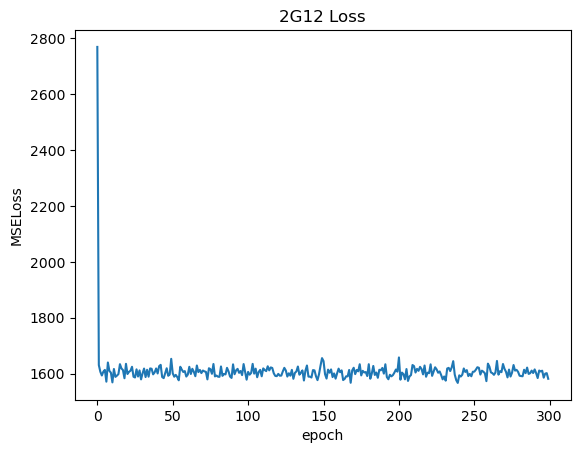

In [27]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("{} Loss".format(name))
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()

In [28]:
#  模型评估 RMSE和R2
RMSE = []
R2 = []

if os.path.exists("./model/pickles/model_{}.pkl".format(name)):
    model.load_state_dict(torch.load("./model/pickles/model_{}.pkl".format(name)))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_{}.pkl".format(name)))
else:
    print("Can not find this model!!!!")



In [69]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the RNN regression model
class RNNRegressionModel(nn.Module):
    def __init__(self):
        super(RNNRegressionModel, self).__init__()
        # self.embedding = nn.Embedding(len(vocabulary), 24)    #每个残基用长度100的向量表示，这里没有用one-hot编码
        #加入LSTM
        self.lstm = nn.LSTM(input_size=24, hidden_size=300, num_layers=1, batch_first=True, bidirectional=False,dropout=dropout)
        self.fc = nn.Linear(300, 2)
    def forward(self, input):
        x = self.embedding(input)   #进行embedding操作,形状[batch_size, max_len,100]
        x, (h_n, c_n) = self.lstm(x)
        #x:[batch_size,max_len,hidden_size]  h_n:[2,batch_size,hiddem_size]
       
        output = h_n[-1,:,:] #正向最后一次的输出
        out = self.fc(output)
        return out

# Hyperparameters
input_size = 21  # Number of amino acids (including padding)
hidden_size = 64  # Number of hidden units in RNN
num_layers = 2  # Number of RNN layers

# Create the model
model = RNNRegressionModel(input_size, hidden_size, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example data
num_samples = 100
sequence_length = 50  # Length of amino acid sequences
protein_sequences = torch.randn(num_samples, sequence_length, input_size)

# Regression targets
regression_targets = torch.randn(num_samples, 1)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(protein_sequences)
    loss = criterion(outputs, regression_targets)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


AttributeError: 'RNNRegressionModel' object has no attribute 'num_layers'